In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
data = pd.read_csv('./data/clean/halving_02_to_04.csv')
data['date'] = pd.to_datetime(data['date'])
data.drop(columns=['name'], inplace=True)
data['year'] = data['date'].dt.year
data['year_group'] = (data['year'] // 4) * 4


In [58]:
def calculate_features(group):
    group = group.sort_values(by='date')

    before_window = 4
    after_window =3

    if len(group) < before_window + after_window:
        return pd.Series({
            'market_cap_mean': np.nan,
            'price_mean': np.nan,
            'price_std': np.nan,
            'circulating_supply_mean': np.nan,
            'volume_24h_mean': np.nan,
            '%1h_mean': np.nan,
            '%7h_mean': np.nan,
            '%24h_mean': np.nan,
            'rank_mean': np.nan,
            'class': np.nan,
            'ismultiplatform': np.nan,
            'target': np.nan
        })
    
    returns = group['price'].pct_change()
    group_before = group.iloc[0:before_window]

    condition = (
        (group['market_cap'].mean() * (1 + group['price'].mean() / 100) > group['market_cap'].mean()) & 
        (group_before['market_cap'].mean() < 1e9) &
        (returns.std() > 0.05) 
    )
    
    target  = condition.astype(int)


    features = {
        'market_cap_mean': group_before['market_cap'].mean(),
        'price_mean': group_before['price'].mean(),
        'price_std': group_before['price'].std(),

        'circulating_supply_mean': group_before['circulating_supply'].mean(),
        'volume_24h_mean': group_before['volume_24h'].mean(),
        
        '%1h_mean': group_before['%1h'].mean(),
        '%7h_mean': group_before['%7h'].mean(),
        '%24h_mean': group_before['%24h'].mean(),
        'rank_mean': group_before['rank'].mean(),
        'class': group_before['class'].iloc[0],
        'ismultiplatform': group_before['ismultiplatform'].iloc[0],
        'target': target       
    }


    return pd.Series(features)



In [59]:
grouped_data = data.groupby(['year_group', 'symbol'])
features_data = grouped_data.apply(calculate_features).reset_index()
features_data.head()

C:\Users\Joseph\AppData\Local\Temp\ipykernel_432\953849529.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_data = grouped_data.apply(calculate_features).reset_index()


,year_group,symbol,level_2,0
0,2016,$$$,market_cap_mean,-2.956542e-02
1,2016,$$$,price_mean,-4.706121e-02
2,2016,$$$,price_std,2.974987e-10
3,2016,$$$,circulating_supply_mean,-6.474114e-02
4,2016,$$$,volume_24h_mean,-3.726444e-02


In [60]:
features_data.dropna(inplace=True)

In [61]:
features_data['target'].value_counts()

KeyError: 'target'

In [ ]:
features_data.drop(columns=['class'], inplace=True)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
X = features_data.drop(columns=['symbol', 'year_group', 'target' ])
y = features_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selector = SelectKBest(f_classif, k=5)
selector.fit(X_train, y_train)
print(X_train.columns[selector.get_support()])

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

Index(['market_cap_mean', 'price_mean', 'volume_24h_mean', 'rank_mean',
       'ismultiplatform'],
      dtype='object')


In [ ]:
smote = SMOTE(random_state=42)
X_train_selected, y_train = smote.fit_resample(X_train_selected, y_train)

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'VotingClassifier': VotingClassifier(estimators=[
        ('RandomForest', RandomForestClassifier(random_state=42)),
        ('GradientBoosting', GradientBoostingClassifier(random_state=42)),
        ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ], voting='hard')

}  

In [ ]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
results = {}
for model_name, model in models.items():
    cv_results = cross_val_score(model, X_train_selected, y_train, cv=kfold, scoring='accuracy')
    results[model_name] = cv_results.mean()
    print(f'{model_name}: {cv_results.mean()}')


RandomForest: 0.9831420990822496
GradientBoosting: 0.9797709248546533


c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

AdaBoost: 0.9735084743305352
SVM: 0.6618566685514622
LogisticRegression: 0.6500566888492598


c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

VotingClassifier: 0.9819387296478332


c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
results = pd.Series(results).sort_values(ascending=False)
results

RandomForest          0.983142
VotingClassifier      0.981939
GradientBoosting      0.979771
AdaBoost              0.973508
SVM                   0.661857
LogisticRegression    0.650057
dtype: float64

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_selected, y_train)
print(grid_search.best_params_)
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_selected, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
865 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Joseph\Desktop\TP-ML\env\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


RandomForestClassifier(bootstrap=False, max_depth=9, n_estimators=300,
                       random_state=42)

In [ ]:
best_rf.score(X_test_selected, y_test)

0.9700934579439252

<Axes: >

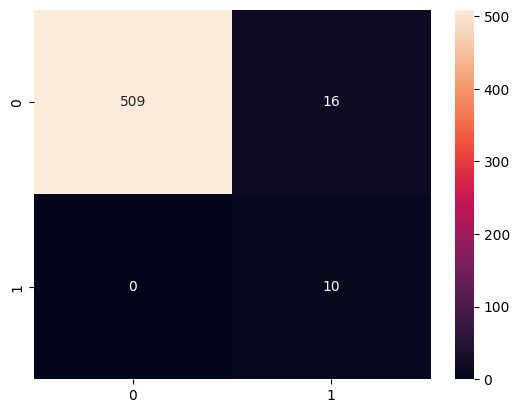

In [ ]:
# Confusion Matrix
y_pred = best_rf.predict(X_test_selected)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

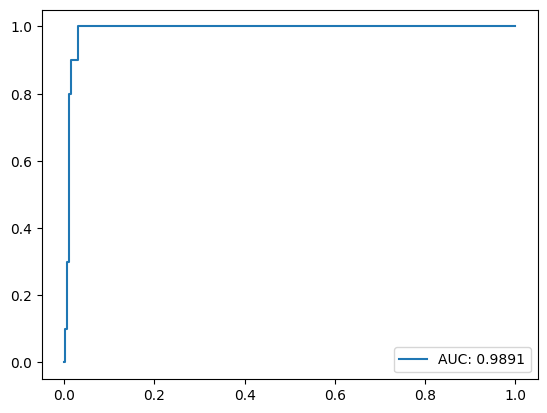

In [ ]:
auc_score = roc_auc_score(y_test, best_rf.predict_proba(X_test_selected)[:, 1])
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test_selected)[:, 1])
plt.plot(fpr, tpr, label=f'AUC: {auc_score:.4f}')
plt.legend()

([0, 1, 2, 3, 4],
 [Text(0, 0, 'price_mean'),
  Text(1, 0, 'volume_24h_mean'),
  Text(2, 0, 'market_cap_mean'),
  Text(3, 0, 'rank_mean'),
  Text(4, 0, 'ismultiplatform')])

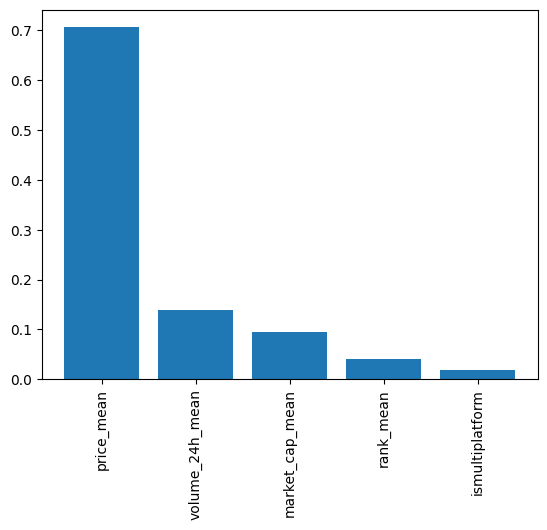

In [ ]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(X_train.columns[selector.get_support()][indices], importances[indices])
plt.xticks(rotation=90)
